In [77]:
using MKL
using DifferentialEquations, LinearAlgebra, SparseArrays, Symbolics, Peaks;
using CSV,DataFrames,JSON
using GLMakie
using Pkg
using StatsBase
using SparseArrays
Makie.inline!(true)
Pkg.add("Colors")
using Plots
using Colors
using Interpolations

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [2]:
df_load = CSV.read("/Users/xcyan/Brown Dropbox/Xingchi Yan/Transfer_Files/Chromatin_Biophysics/Antibody_Draft/antibody_julia/change_on/1210_change_on_Rodas5P_75/diffuse_spherical_sol_on_16_11.csv", DataFrame);

In [3]:
function extract_data(u_data::Vector{String}, time, indicator)
    # Step 1: Remove the square brackets and split the string by semicolons into rows
    rows = split(strip(u_data[time], ['[', ']']), ";")
    # Step 2: Extract the second column (3rd element in each row) and store as a vector of strings
    second_column = [split(row)[indicator] for row in rows]
    # Step 3: Convert the second column from string to Float64
    numbers = parse.(Float64, second_column)
    # Return the second column as numbers
    return numbers
end

extract_data (generic function with 1 method)

In [ ]:
time = df_load.time
u_data = df_load.u
# rows = split(strip(u_data[1], ['[', ']']), ";")
# second_column = [split(row)[3] for row in rows]
# numbers = parse.(Float64, second_column)
## parameters 
r_limit = 75     # Maximum radial distance
N_r = 7500           # Number of radial grid points
rgrid = range(0, stop=r_limit, length=N_r)
dr = step(rgrid);

### Visualize the time evolution of the the concentration field in 1D
#### Here shows the concentration field at half-hour as an example

In [16]:
## time points, here 1-t=0; 181-t=1/2h; 361-t=1h
time_points = [1, 181, 361] 
# Extract profiles at the initial, middle, and last time steps
profile_1 = extract_data(u_data, time_points[1], 3) # Initial time step
profile_2 = extract_data(u_data, time_points[2], 3) # Middle time step
profile_3 = extract_data(u_data, time_points[3], 3) # Middle time step
# take the region of interest for plot, here 10um from the center of the nuclues
region_of_interest = rgrid .<= 10
rgrid_filtered = rgrid[region_of_interest] 
profile_1_filtered = profile_1[region_of_interest]
profile_2_filtered = profile_2[region_of_interest]
profile_3_filtered = profile_3[region_of_interest];

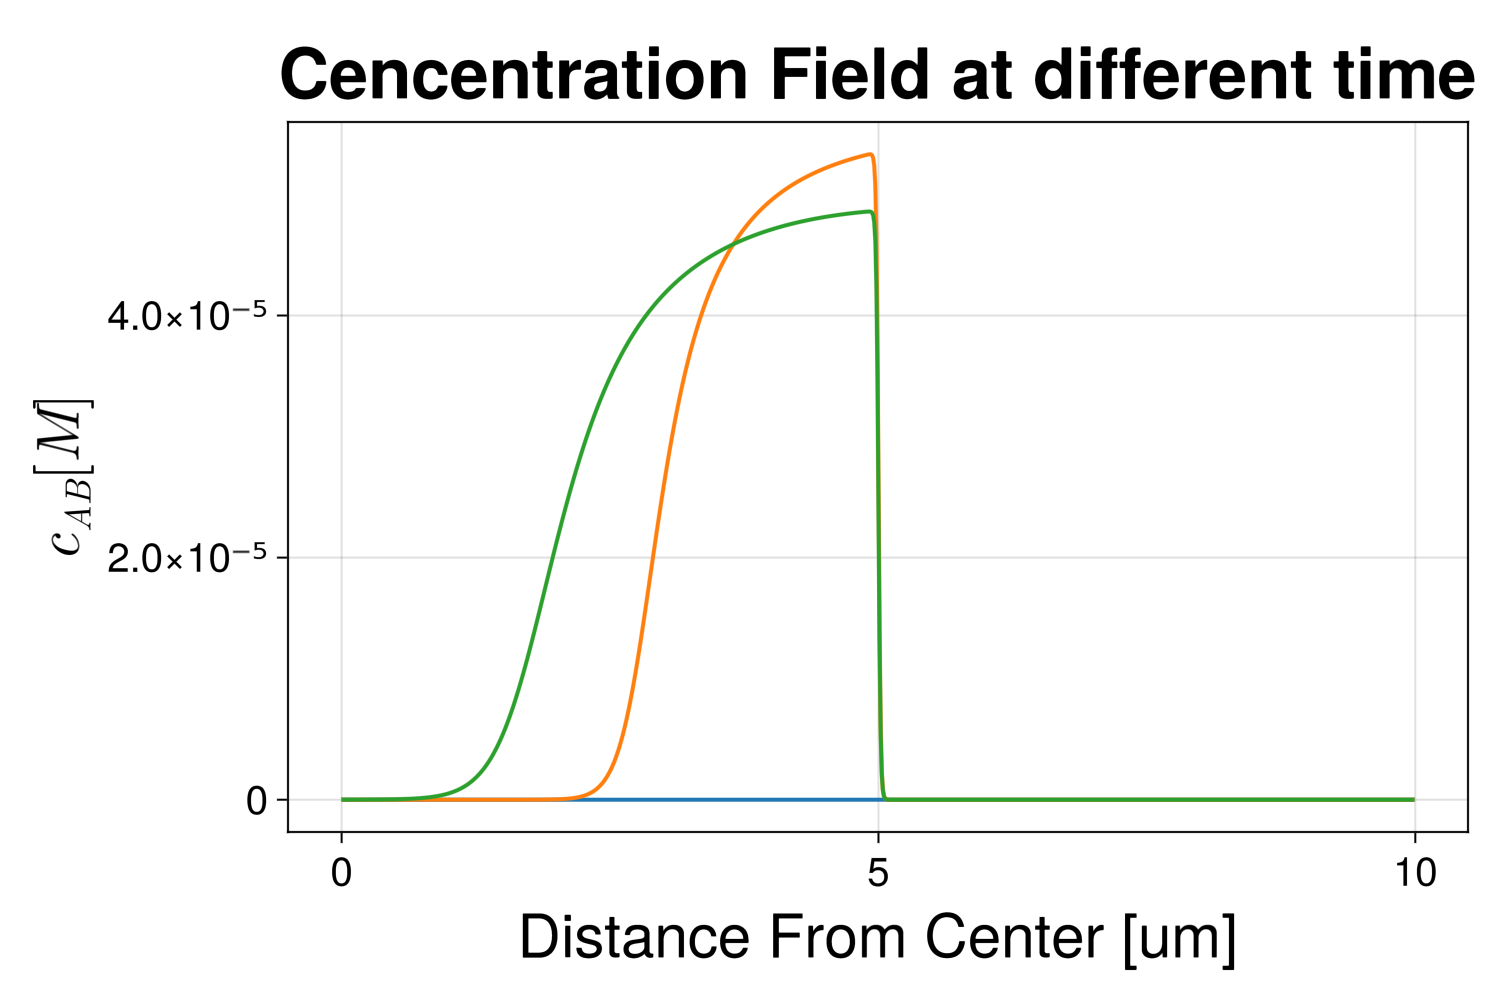

GLMakie.Screen(...)

In [17]:
fig = Figure(size = (750, 500), fontsize = 20)
# Create the axis
ax = Axis(fig[1, 1], title = "Cencentration Field at different time", 
        xlabel = "Distance From Center [um]", 
        ylabel=L"c_{AB} [M]",
        xlabelsize=30, ylabelsize=30, titlesize=35)

# Define the tab10 color palette (these are the colors from Seaborn's tab10)
tab10_colors = [
        RGB(0.121568, 0.466667, 0.705882),  # Blue
        RGB(1.000000, 0.498039, 0.054902),  # Orange
        RGB(0.172549, 0.627451, 0.172549),  # Green
        RGB(0.839216, 0.152941, 0.156863),  # Red
        RGB(0.580392, 0.403922, 0.741176),  # Purple
        RGB(0.549020, 0.337255, 0.294118),  # Brown
        RGB(0.890196, 0.466667, 0.760784),  # Pink
        RGB(0.498039, 0.498039, 0.498039),  # Gray
        RGB(0.737255, 0.741176, 0.133333),  # Olive
        RGB(0.090196, 0.745098, 0.811765)  # Cyan
    ]

# Define the plot using the correct color names from the Colors.jl library
lines!(ax, rgrid_filtered, profile_1_filtered, label = "t=0", color = tab10_colors[1], linewidth = 2)
lines!(ax, rgrid_filtered, profile_2_filtered, label = "t=15 min", color = tab10_colors[2], linewidth = 2)
lines!(ax, rgrid_filtered, profile_3_filtered, label = "t=30 min", color = tab10_colors[3], linewidth = 2)

# Legend(fig[1, 2], ax, label = ["Numerical Initial", "Numerical Middle", "Numerical Last"], position = :topright)
# Display the plot
display(fig)

### Visualize the concentration field at given timepoint
#### Here shows the concentration field at half-hour as an example

In [ ]:
profile_half_hour = extract_data(u_data, time_points[2], 3) # Middle time step
MAX_RADIUS = 10
region_of_interest = rgrid .<= MAX_RADIUS
rgrid_filtered = rgrid[region_of_interest] 
profile_half_hour_filtered = profile_half_hour[region_of_interest];

In [ ]:
## Can save the files
# using DelimitedFiles
# data_sub_plt = max.(profile_half_hour_filtered, 0)
# writedlm("x_array.txt", rgrid_filtered)
# writedlm("concentration_array.txt", data_sub_plt)
# x = readdlm("x_array.txt")  # Load data as an array
# data_half_hour = readdlm("concentration_array.txt")  # Load data as an array

In [51]:
# Assuming x and data_1_2 are arrays
data_sub_plt = max.(profile_half_hour_filtered, 0);
x_sub = rgrid_filtered[1:Int(length(data_sub_plt))];  # Select the first 'length(data_1_2)' elements from x
# Select the first 'length(data_1_2)' elements from data_1_2
# For the first 10% of data: total length 75um, 10% is 7.5um
# data_half_hour_10_percent = data_sub_plt[1:Int(0.1 * length(data_sub_plt))]  # Select first 10% of the data
data_half_hour_sub = data_sub_plt[1:Int(length(data_sub_plt))];

In [44]:
function generate_radius_2D_new(side_length, shape)
    # Create a grid of size `shape x shape`
    y, x = [i for i in 1:shape, j in 1:shape], [j for i in 1:shape, j in 1:shape]
    # Define the center of the matrix
    center = (shape ÷ 2, shape ÷ 2)
    # Calculate the Euclidean distance from the center for each point
    radius_image = sqrt.((x .- center[2]).^2 + (y .- center[1]).^2)
    # Normalize the distance such that the maximum distance equals side_length / 2
    max_distance = sqrt(2) * (shape ÷ 2)  # max distance to the corner of the matrix
    scaled_radius_image = (radius_image / max_distance) * (side_length / 2) * sqrt(2)  
    return scaled_radius_image
end

function apply_function_to_radius(radius_image, func)
    # Apply the function to the radius values
    return func.(radius_image)
end

x_sub_plt_center = rgrid_filtered[1:length(data_half_hour_sub)]
data_sub_plt_center = data_half_hour_sub[1:length(data_half_hour_sub)]

# Create interpolation function
interp = LinearInterpolation(x_sub_plt_center, data_sub_plt_center, extrapolation_bc=Line())
# Generate the radius image
radius_image = generate_radius_2D_new(20, 1000)
# Apply the function to the radius image using the interpolation
result_image = apply_function_to_radius(radius_image, interp)
# Apply maximum to ensure no negative values
result_image = max.(result_image, 0)
# Take log of the image for display
small_constant = 1e-15
result_image_log = log10.(result_image .+ small_constant);

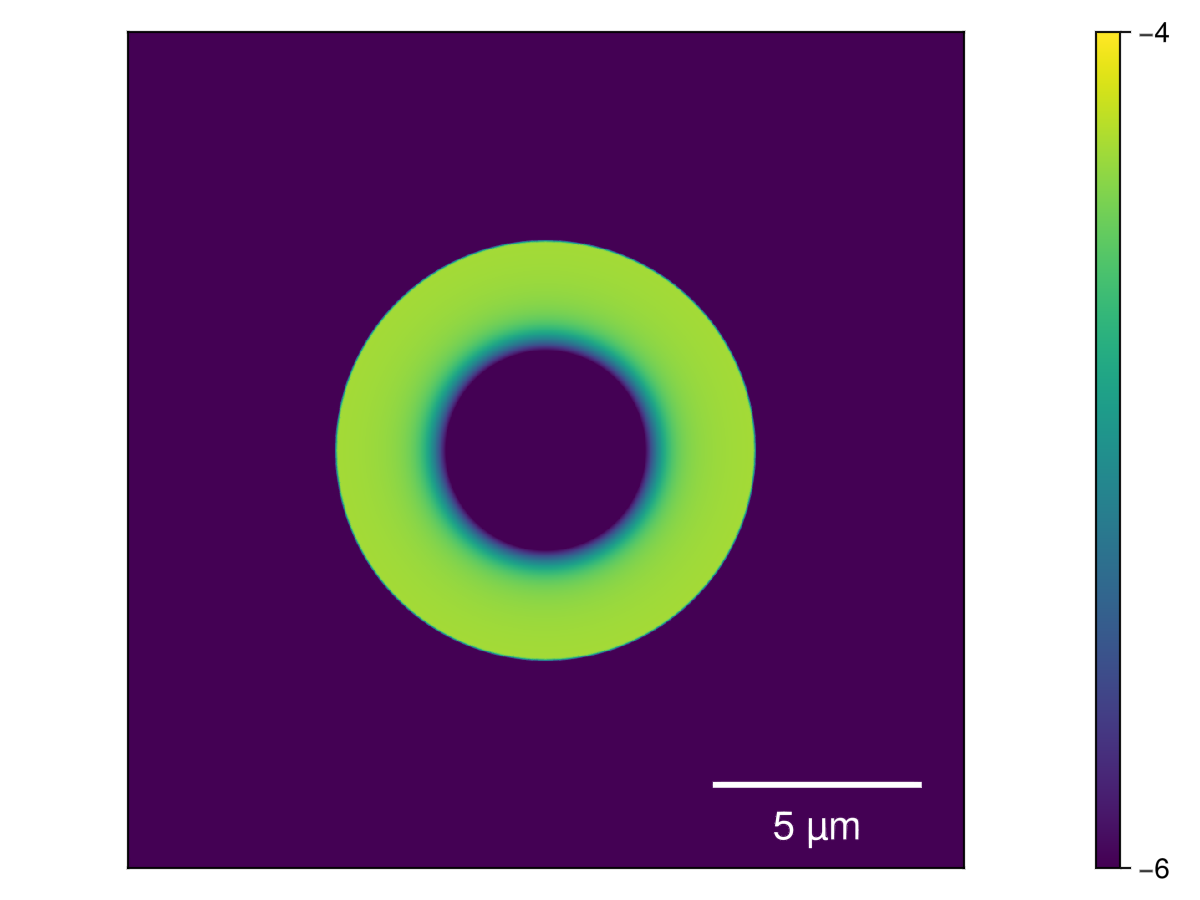

GLMakie.Screen(...)

In [76]:
# Create a figure
fig = Figure()
# Create an axis
ax = Axis(fig[1, 1], aspect=DataAspect())
# Create the heatmap using GLMakie's heatmap function, using a scale bar of range (-6, -4), may change
hm = GLMakie.heatmap!(ax, result_image_log, colorrange=(-6, -4))
# Remove decorations
hidedecorations!(ax)
# Add colorbar
cbar = Colorbar(fig[1, 2], hm, ticks=[-6, -4])
# Add text "log c_{AB}" next to the colorbar
annotate!(fig[1, 2], (1.05, 0.5), "log c_{AB}", color=:black, fontsize=12, align=:left)
# Display the figure

# Add scale bar
scalebar_length = 1000/4  # Length in data units (µm)
scalebar_position_x = 700
scalebar_position_y = 100
scalebar_height = 10 # Thickness of the bar

# Draw the scale bar line
lines!(ax, 
      [scalebar_position_x, scalebar_position_x + scalebar_length], 
      [scalebar_position_y, scalebar_position_y], 
      color=:white, linewidth=3)

# Add the scale bar text
text!(ax, 
     scalebar_position_x + scalebar_length/2, 
     scalebar_position_y - scalebar_height*2, 
     text="5 µm",
     color=:white, 
     align=(:center, :top),
     fontsize=20)

display(fig)